In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Drive

In [ ]:
# acess files from google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/adex_netpyne/

/content/drive/MyDrive/adex_netpyne


# Getting data

In [2]:
# !pip install neuron
# !pip install netpyne 
import matplotlib
import os
import json

In [71]:
# !git clone -b LFP https://github.com/suny-downstate-medical-center/S1_netpyne.git
# os.listdir('.')

# Compile mod/

In [78]:
!nrnivmodl mod/

/home/fernando/Downloads/adex-main
Mod files: "mod/Adex.mod"

Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.cpp
 -> NMODL ../mod//Adex.mod
Translating Adex.mod into /home/fernando/Downloads/adex-main/x86_64/Adex.c
Thread Safe
 -> Compiling Adex.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


# cfg.py

In [63]:
"""
cfg.py 

Simulation configuration for adex model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com, javier@gmail.com
"""

from netpyne import specs
import pickle
import os
import numpy as np

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 1.0*1e3 ## Duration of the sim, in ms  
cfg.dt = 0.005
cfg.seeds = {'conn': 4322, 'stim': 4322, 'loc': 4322} 
cfg.hParams = {'celsius': 34, 'v_init': -65}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 2.0

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True
cfg.checkErrors = False

#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
cfg.rootFolder = os.getcwd()
cfg.allpops = ['E']

#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.cellsrec = 0
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop

cfg.recordTraces = {'V_soma': {'sec':'soma', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False			
cfg.recordTime = False  		
cfg.recordStep = 0.005           

#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'v0_batch0'
cfg.saveFolder = 'data/'+cfg.simLabel
# cfg.filename =                	## Set file output name
cfg.savePickle = False	        	## Save pkl file
cfg.saveJson = False           	## Save json file
cfg.saveDataInclude = ['simData', 'simConfig', 'netParams', 'net'] ## , 'simConfig', 'netParams'
cfg.backupCfgFile = None 		##  
cfg.gatherOnlySimData = False	##  
cfg.saveCellSecs = True			
cfg.saveCellConns = True	

#------------------------------------------------------------------------------
# Analysis and plotting 
# ------------------------------------------------------------------------------
cfg.analysis['plotRaster'] = {'saveFig': True, 'showFig': False, 'orderInverse': True, 'timeRange': [0,cfg.duration], 'figSize': (24,6), 'fontSize':8, 'dpi': 300} 
cfg.analysis['plot2Dnet']   = {'include': cfg.allpops, 'saveFig': True, 'showConns': True, 'figSize': (6,6), 'fontSize':16}   # Plot 2D cells xy
cfg.analysis['plotTraces'] = {'include': cfg.recordCells, 'oneFigPer': 'trace', 'overlay': False, 'ylim': [-70,-35], 'timeRange': [0,cfg.duration], 'saveFig': True, 'showFig': False, 'figSize':(12,36)}
cfg.analysis['plotShape'] = {'includePre': cfg.recordCells, 'includePost': cfg.recordCells, 'showFig': False, 'includeAxon': False, 
                            'showSyns': False, 'saveFig': True, 'dist': 0.55, 'cvar': 'voltage', 'figSize': (6,6), 'dpi': 300}
#------------------------------------------------------------------------------
# Network 
#------------------------------------------------------------------------------
cfg.scale = 1.0 # reduce size
cfg.sizeY = 20.0
cfg.sizeX = 20.0 # um
cfg.sizeZ = 20.0
cfg.scaleDensity = 1.0 # Number of cells

#------------------------------------------------------------------------------
# Current inputs 
#------------------------------------------------------------------------------
cfg.addIClamp = True  # decrease the transient
 
cfg.IClamp = []
cfg.IClampnumber = 0

for popName in ['E']:
    cfg.IClamp.append({'pop': popName, 'sec': 'soma', 'loc': 0.5, 'start': 0, 'dur': 100000, 'amp': 0.0025}) #pA?, reobase->'amp': 0.0013}
    cfg.IClampnumber=cfg.IClampnumber+1

# netParams.py

In [64]:

"""
netParams.py

High-level specifications for adex network model using NetPyNE

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com, javier@gmail.com
"""

from netpyne import specs

netParams = specs.NetParams()   # object of class NetParams to store the network parameters

#------------------------------------------------------------------------------
#
# NETWORK PARAMETERS
#
#------------------------------------------------------------------------------

#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------
netParams.scale = cfg.scale # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume
   
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -35.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

#------------------------------------------------------------------------------
# Population parameters
#------------------------------------------------------------------------------
netParams.popParams['E'] = {'cellType': 'PYR', 'numCells': 15, 'cellModel': 'Adex'}

#------------------------------------------------------------------------------
# Cell parameters
#------------------------------------------------------------------------------
### AdEx2007 (section voltage)
firing = 'adaptation'
netParams.importCellParams(
    label='PYR_Adex_rule', 
    conds={'cellType': 'PYR', 'cellModel':'Adex'},
    fileName='cells/adexWrapper.py', 
    cellName='AdExCell',  
    cellArgs={'type':firing},
    )
netParams.renameCellParamsSec('PYR_Adex_rule', 'sec', 'soma')  # rename imported section 'sec' to 'soma'

#------------------------------------------------------------------------------    
# Current inputs (IClamp)
#------------------------------------------------------------------------------
if cfg.addIClamp:
     for j in range(cfg.IClampnumber):
        key ='IClamp'
        params = getattr(cfg, key, None)
        key ='IClamp'+str(j+1)
        params = params[j]
        [pop,sec,loc,start,dur,amp] = [params[s] for s in ['pop','sec','loc','start','dur','amp']]

        # add stim source
        netParams.stimSourceParams[key] = {'type': 'IClamp', 'delay': start, 'dur': dur, 'amp': amp}
        
        # connect stim source to target
        netParams.stimTargetParams[key+'_'+pop] =  {
            'source': key, 
            'conds': {'pop': pop},
            'sec': sec, 
            'loc': loc}

In [65]:
%matplotlib inline

# init.py

In [66]:
"""
init.py
Starting script to run NetPyNE-based model.
Usage:
    python init.py # Run simulation, optionally plot a raster
MPI usage:
    mpiexec -n 4 nrniv -python -mpi init.py
Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import sim

# cfg, netParams = sim.readCmdLineArgs()
# cfg, netParams = sim.readCmdLineArgs(simConfigDefault='cfg.py', netParamsDefault='netParams.py')

sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params
sim.net.createPops()               			# instantiate network populations
sim.net.createCells()              			# instantiate network cells based on defined populations
sim.net.connectCells()            			# create connections between cells based on params
sim.net.addStims() 							# add network stimulation


Start time:  2022-04-27 19:02:49.191321

Creating network of 1 cell populations on 1 hosts...
  Number of cells on node 0: 15 
  Done; cell creation time = 0.00 s.
Making connections...
  Number of connections on node 0: 0 
  Done; cell connection time = 0.00 s.
Adding stims...
  Number of stims on node 0: 15 
  Done; cell stims creation time = 0.00 s.


[[{label: 'IClamp1_E', source: 'IClamp1', sec: 'soma', loc: 0.5, type: 'IClamp', delay: 0, dur: 100000, amp: 0.0025, hObj: IClamp[50]}],
 [{label: 'IClamp1_E', source: 'IClamp1', sec: 'soma', loc: 0.5, type: 'IClamp', delay: 0, dur: 100000, amp: 0.0025, hObj: IClamp[51]}],
 [{label: 'IClamp1_E', source: 'IClamp1', sec: 'soma', loc: 0.5, type: 'IClamp', delay: 0, dur: 100000, amp: 0.0025, hObj: IClamp[52]}],
 [{label: 'IClamp1_E', source: 'IClamp1', sec: 'soma', loc: 0.5, type: 'IClamp', delay: 0, dur: 100000, amp: 0.0025, hObj: IClamp[53]}],
 [{label: 'IClamp1_E', source: 'IClamp1', sec: 'soma', loc: 0.5, type: 'IClamp', delay: 0, dur: 100000, amp: 0.0025, hObj: IClamp[54]}],
 [{label: 'IClamp1_E', source: 'IClamp1', sec: 'soma', loc: 0.5, type: 'IClamp', delay: 0, dur: 100000, amp: 0.0025, hObj: IClamp[55]}],
 [{label: 'IClamp1_E', source: 'IClamp1', sec: 'soma', loc: 0.5, type: 'IClamp', delay: 0, dur: 100000, amp: 0.0025, hObj: IClamp[56]}],
 [{label: 'IClamp1_E', source: 'IClamp1',

In [67]:
sim.net.cells[8].stims[0]['amp']

0.0025

In [68]:
for i, neuroni in enumerate(sim.net.cells):
        
        neuroni.stims[0]['amp'] = 0.00125 + i*0.000125
        neuroni.stims[0]['hObj'].amp = 0.00125 + i*0.000125
        print(i, 0.00125 + i*0.000125)

0 0.00125
1 0.001375
2 0.0015
3 0.0016250000000000001
4 0.00175
5 0.001875
6 0.002
7 0.002125
8 0.0022500000000000003
9 0.0023750000000000004
10 0.0025
11 0.0026249999999999997
12 0.00275
13 0.002875
14 0.003


In [69]:
sim.net.cells[8].stims[0]['hObj'].amp

0.0022500000000000003

Recording 15 traces of 1 types on node 0
0.0s

Running simulation using NEURON for 1000.0 ms...
  Done; run time = 0.78 s; real-time ratio: 1.29.

Gathering data...
  Done; gather time = 0.15 s.

Analyzing...
  Cells: 15
  Connections: 0 (0.00 per cell)
  Spikes: 186 (12.40 Hz)
  Simulated time: 1.0 s; 1 workers
  Run time: 0.78 s
   E : 12.400 Hz
Preparing spike data...
Plotting raster...
Plotting 2D representation of network cell locations and connections...


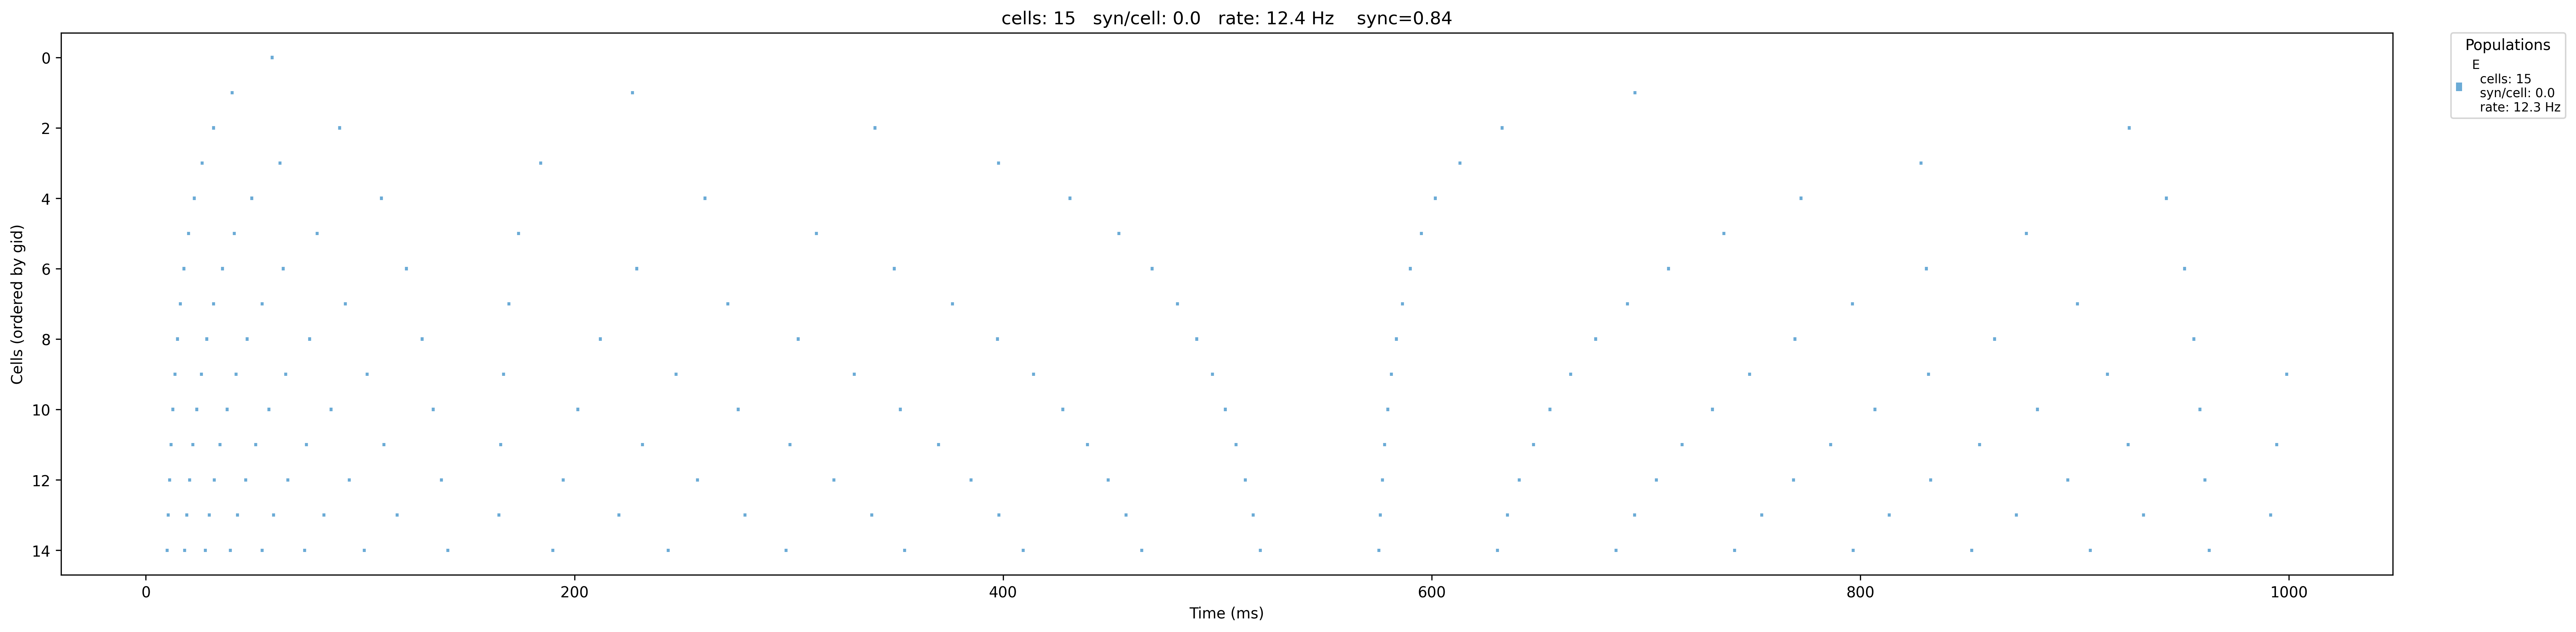

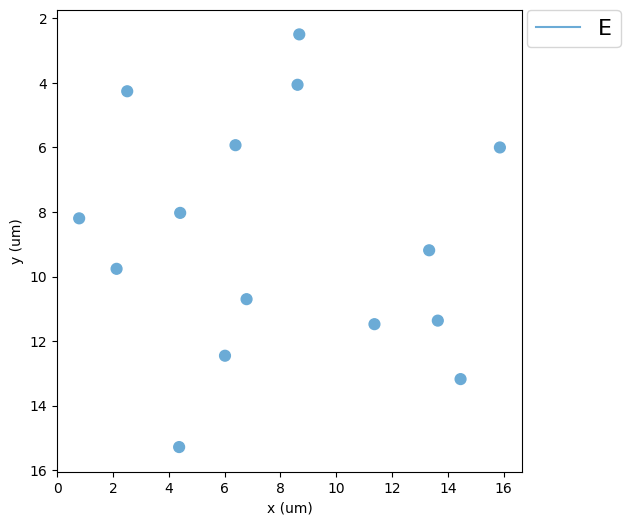

Plotting recorded cell traces ... trace
Plotting 3D cell shape ...
  Done; plotting time = 1.99 s


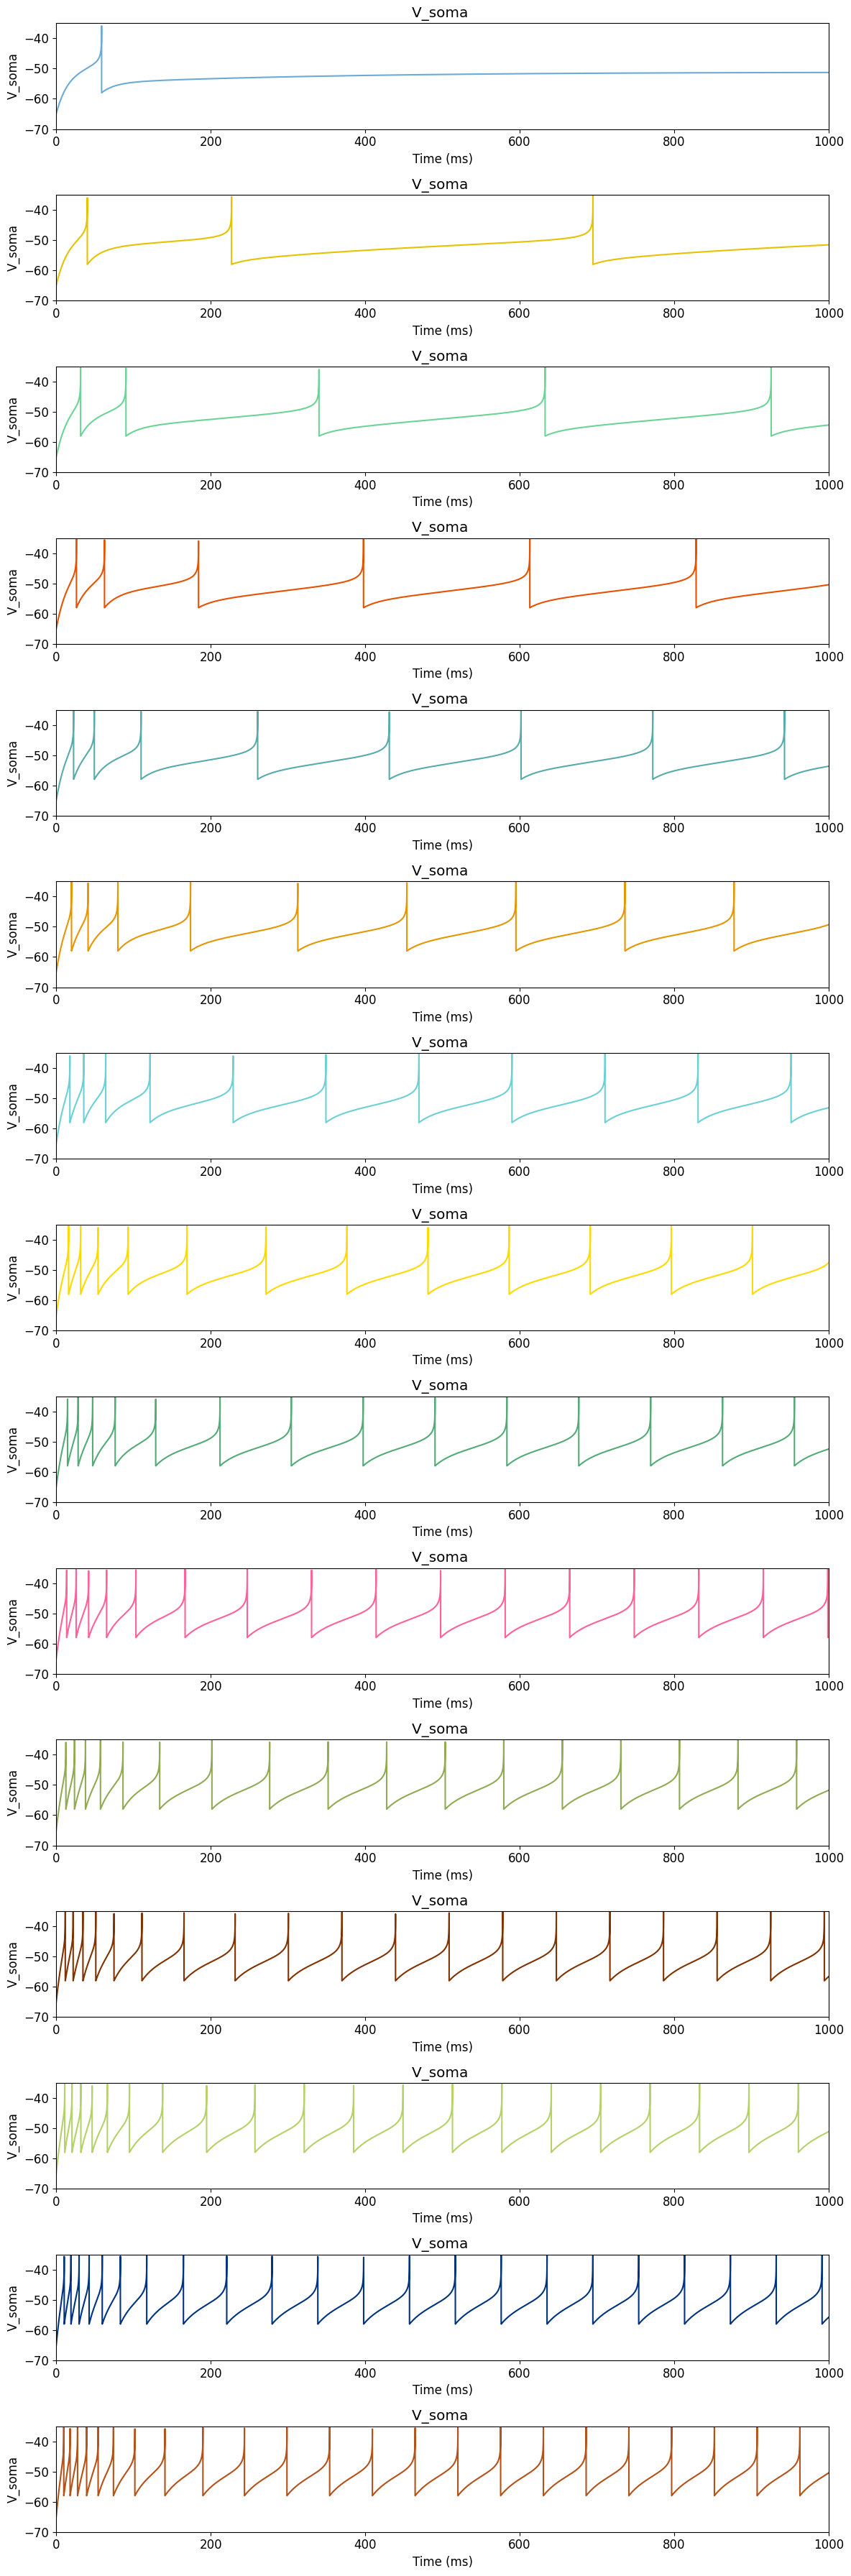

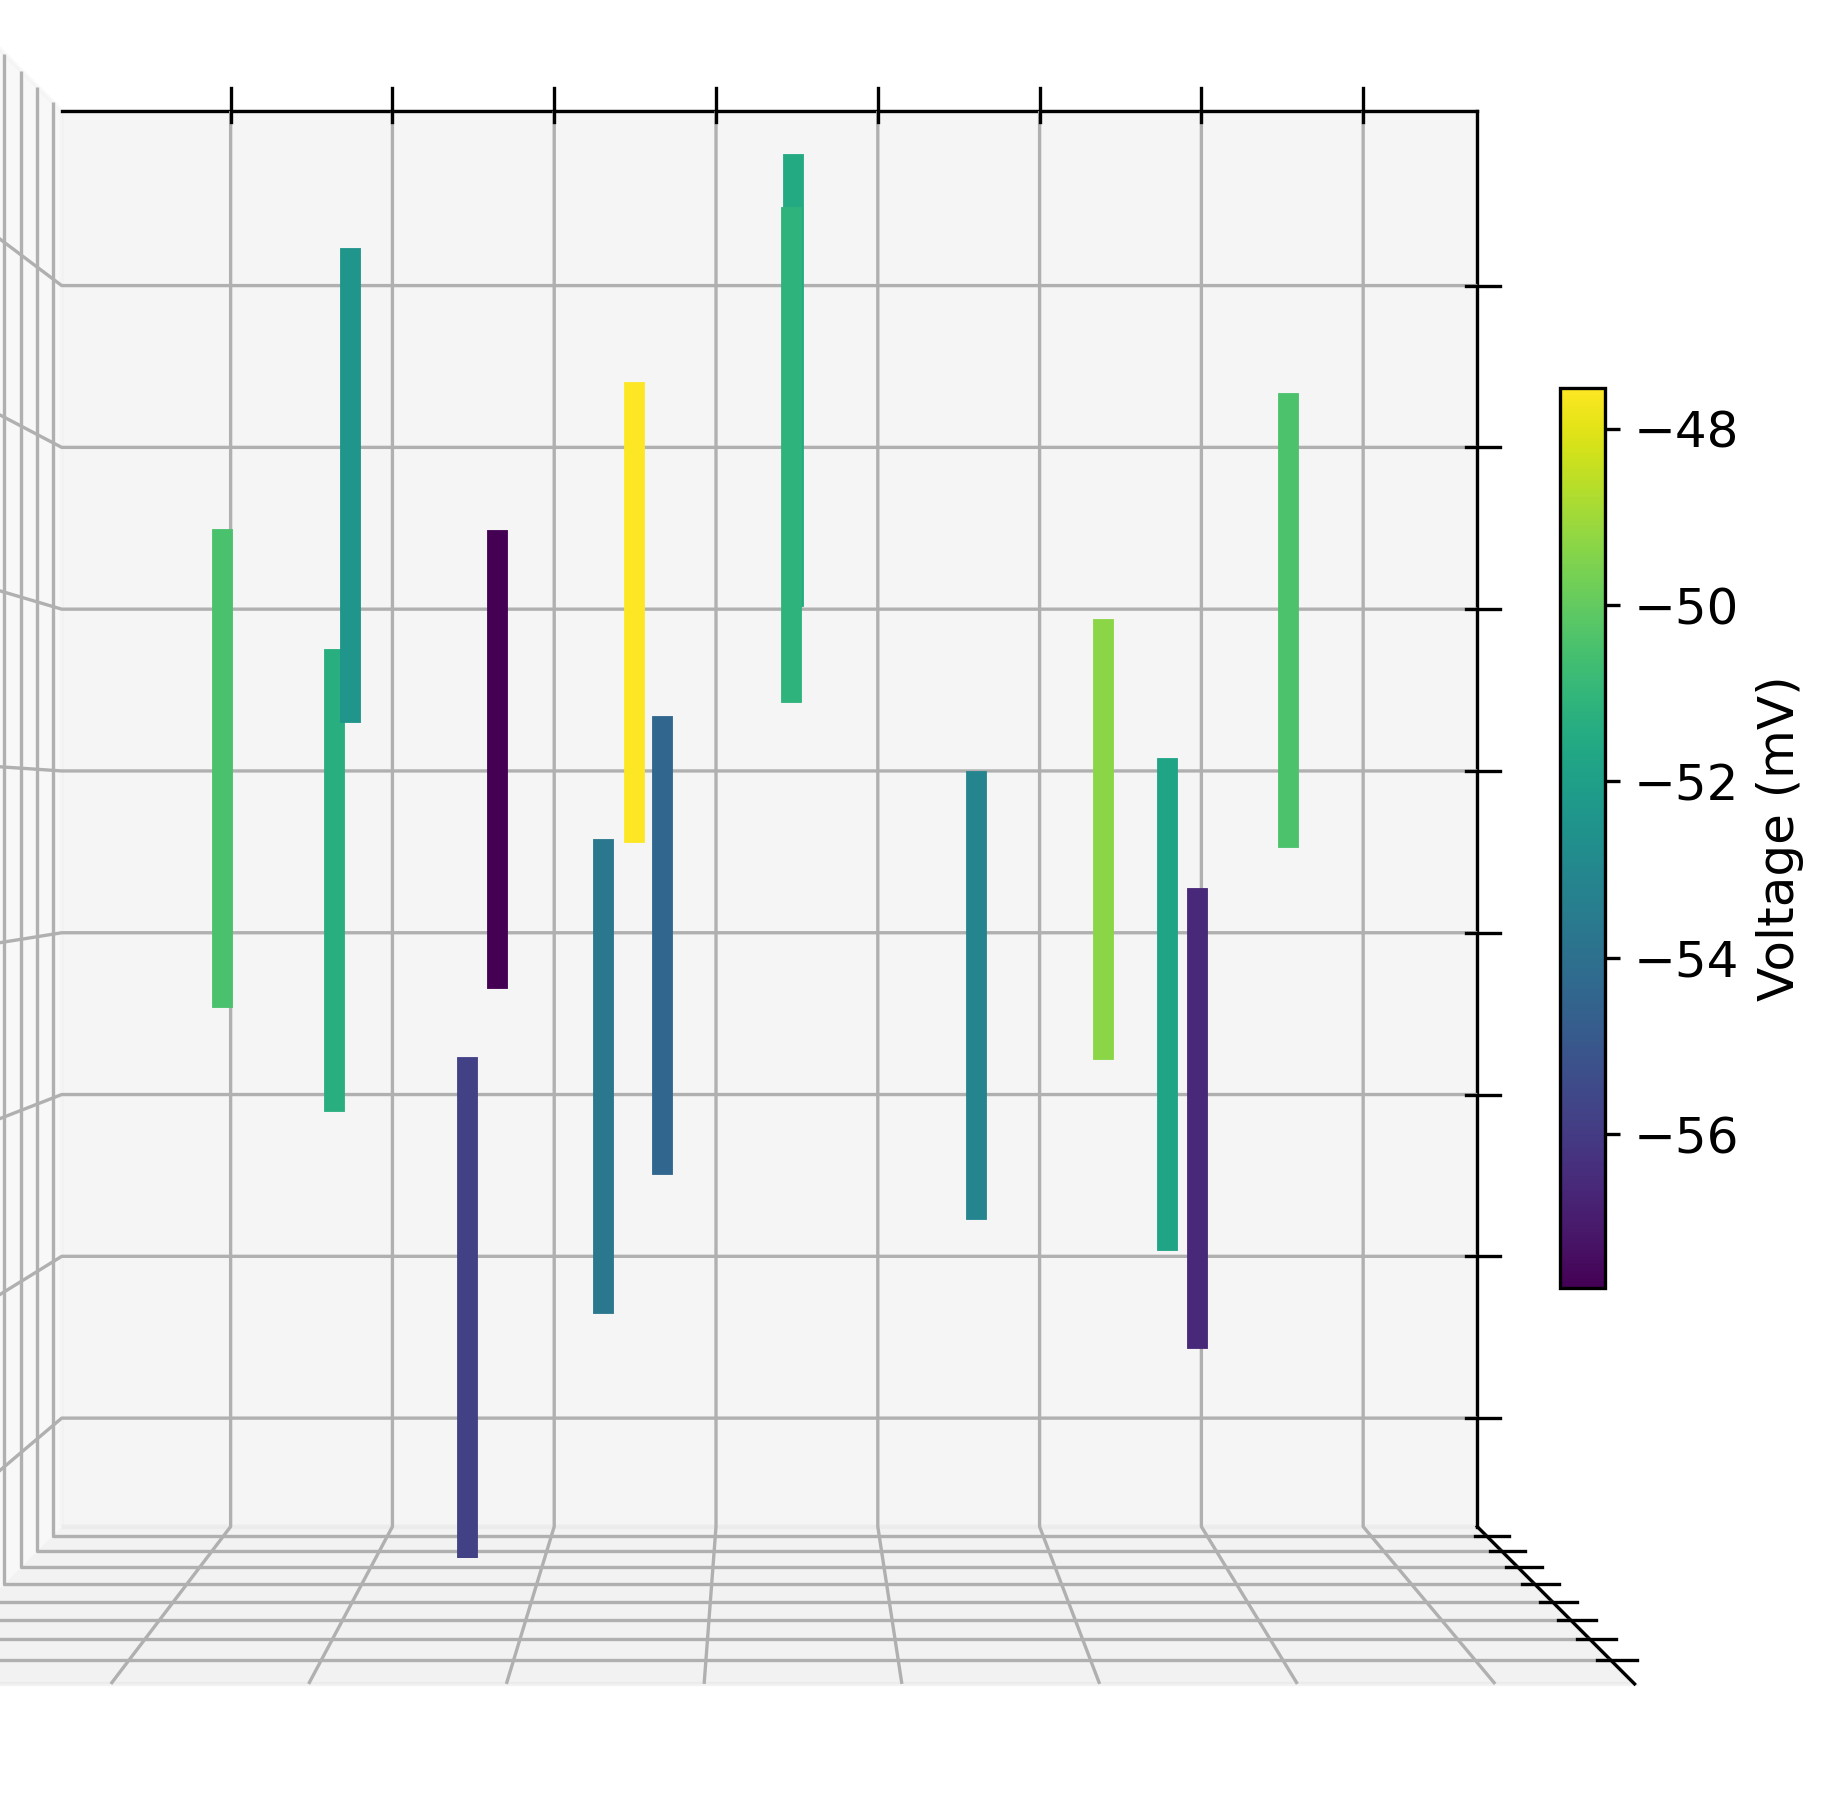

In [70]:
sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()         			# plot spike raster etc